# Customer Churn Prediction

As customer recruitment is normally expensive, losing customers might be a nightmare for a business. 

In churn management, it is important to
- identify customers who are likely to stop using a service
- identify factors which trigger the decision

In this project, I build a model based on the random forest method which can be used to serve the two goals mentioned above. The accuracy of the model predictions reached up to 95%. Among all customers, 14.5% tend to churn. The model could successfully identify 70-75% of them. Important factors (ranked) are: total day charge, customer service calls, total evening charge, international plan.  

 ### Content
- Part 1: Exploratory data analysis (EDA)
- Part 2: Model training and evaluation
- Part 3: Important features selection
- Part 4: Final Model

Data source: https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

## Part 1: EDA

### Part 1.1: Load Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

from quickLib import *

pd.set_option('display.max_columns', 100)
%matplotlib inline

In [2]:
churn_df = pd.read_csv('data/bigml.csv')
churn_df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
print ("Num of rows: " + str(churn_df.shape[0])) # row count
print ("Num of columns: " + str(churn_df.shape[1])) # col count

Num of rows: 3333
Num of columns: 21


In [83]:
churn_percent = churn_df['churn'].sum().astype(float)/len(churn_df['churn'])
'{:2.2%} of all customers tend to leave'.format(churn_percent)

'14.49% of all customers tend to leave'

### Part 1.2: Data cleaning 
missing data, outliers, correct data types etc.

In [4]:
missing_data(churn_df)

,Total,Percent
churn,0,0.0
total day charge,0,0.0
account length,0,0.0
area code,0,0.0
phone number,0,0.0
international plan,0,0.0
voice mail plan,0,0.0
number vmail messages,0,0.0
total day minutes,0,0.0
total day calls,0,0.0


In [5]:
churn_df.dtypes

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

In [6]:
churn_df['area code'] = churn_df['area code'].astype(object)
churn_df['churn'] = np.where(churn_df['churn'] == True,1,0)

### Part 1.3: Understand the features

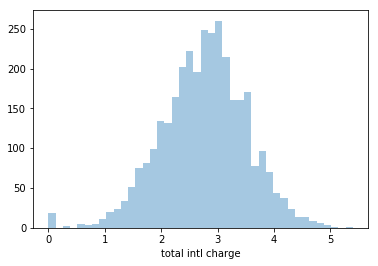

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(churn_df['total intl charge'], kde=False)

In [8]:
# Select the numeric columns
cols = ['account length', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls','churn']      

# Find correlations with the sale price 
correlations = churn_df[cols].corr()

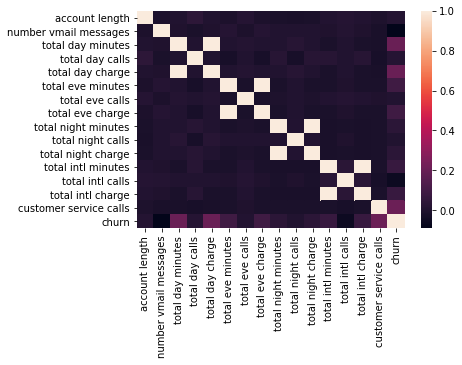

In [9]:
sb.heatmap(correlations)

## Part 2: Model training and evaluation

In [10]:
cat_train(churn_df)

In [11]:
X, y, na_dict = prep_df(churn_df, 'churn')

In [12]:
X.shape, na_dict

((3333, 20), {})

In [13]:
## keep 20% for test later
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_index, test_index = next(kfold.split(X, y))
len(train_index), len(test_index)

(2666, 667)

In [14]:
def split_test(X, y):
    X_train = X.iloc[train_index]
    y_train = y[train_index]

    X_test = X.iloc[test_index]
    y_test = y[test_index]
    return X_train, y_train, X_test, y_test

In [16]:
from sklearn.ensemble import RandomForestClassifier
X_train, y_train, X_test, y_test = split_test(X, y)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)

### Model evaluation: confusion matrix

In [17]:
def confusion_df(y_test,pred):
    return pd.DataFrame(confusion_matrix(y_test,pred),
             columns=["Predicted Class " + str(class_name) for class_name in [0,1]],
             index = ["Class " + str(class_name) for class_name in [0,1]])

In [19]:
m.fit(X_train, y_train)
pred = m.predict(X_test)
print(confusion_df(y_test, pred))

         Predicted Class 0  Predicted Class 1
Class 0                564                  6
Class 1                 21                 76


## Part3: Important Feature Selection 

In [20]:
fi = rf_feat_importance(m, X); fi[:10]

,cols,imp
7,total day minutes,0.165328
9,total day charge,0.130537
19,customer service calls,0.122209
4,international plan,0.082476
12,total eve charge,0.080199
17,total intl calls,0.072884
10,total eve minutes,0.068663
18,total intl charge,0.040896
16,total intl minutes,0.037021
6,number vmail messages,0.031177


In [21]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

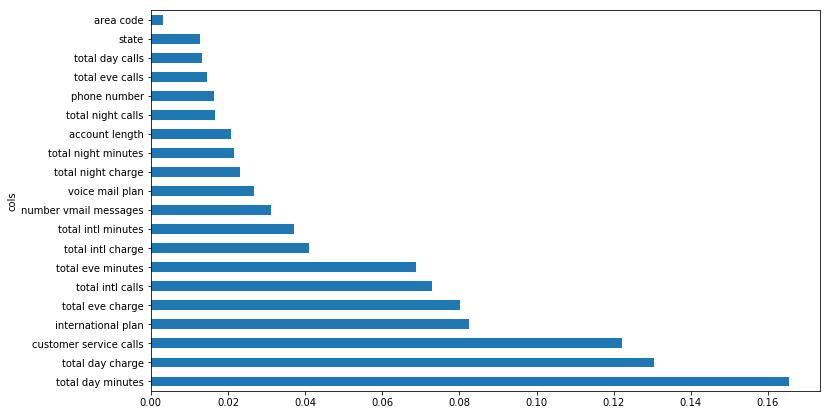

In [22]:
plot_fi(fi);

In [23]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
X_keep = X[to_keep].copy()

In [24]:
X2, y, _ = prep_df(churn_df, 'churn', max_n_cat=7)

X_train2, y_train, X_test2, y_test = split_test(X2, y)

m.fit(X_train2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [25]:
pred = m.predict(X_test2)
print(confusion_df(y_test, pred))

         Predicted Class 0  Predicted Class 1
Class 0                563                  7
Class 1                 22                 75


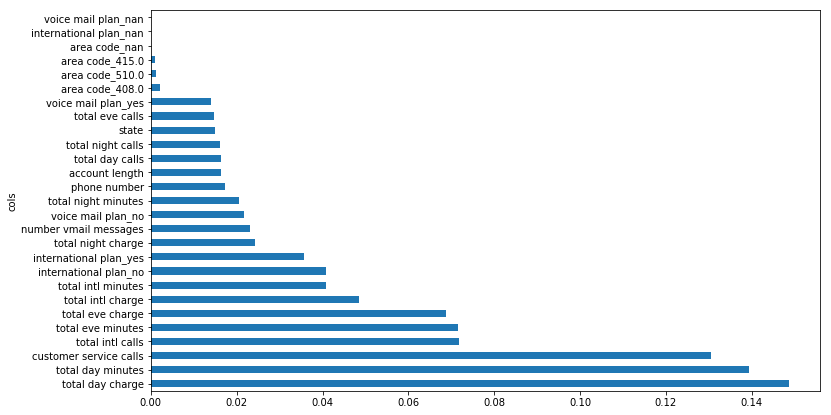

In [26]:
fi = rf_feat_importance(m, X2)
plot_fi(fi);

### Removing redundant features

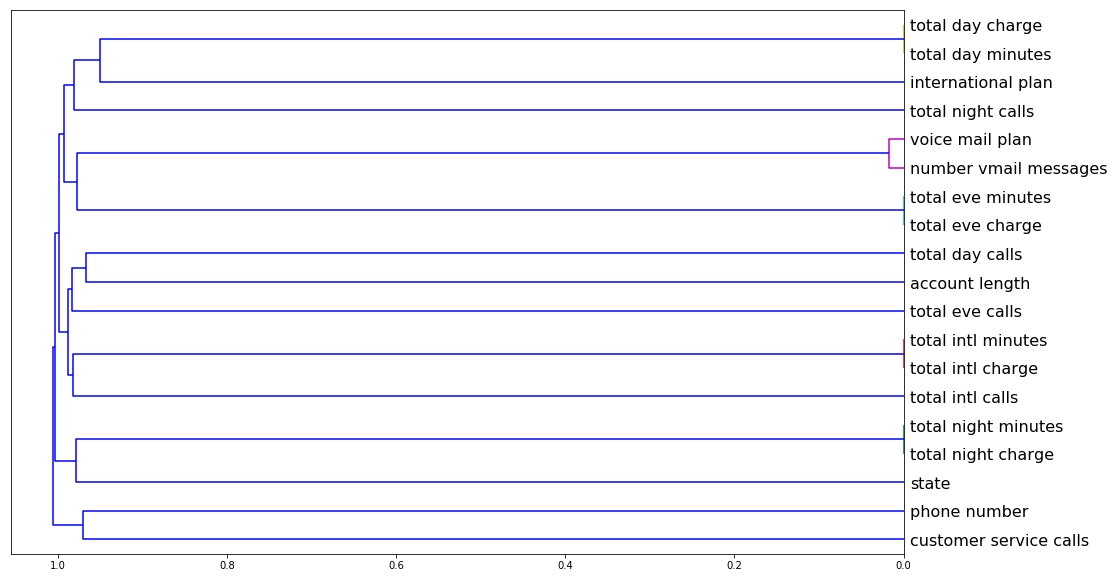

In [27]:
corr = np.round(scipy.stats.spearmanr(X_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [28]:
def get_oob(X, y):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)   
    m.fit(X, y)
    return m.oob_score_

In [29]:
get_oob(X_keep, y)

0.9525952595259526

In [30]:
for c in ('total day minutes','total day charge', 'total eve minutes','total eve charge',
          'total intl minutes','total intl charge', 'total night minutes','total night charge', 'voice mail plan',
       'number vmail messages'):
    print(c, get_oob(X_keep.drop(c, axis=1), y))

total day minutes 0.9528952895289529
total day charge 0.9513951395139514
total eve minutes 0.9510951095109511
total eve charge 0.9543954395439544
total intl minutes 0.9555955595559555
total intl charge 0.9543954395439544
total night minutes 0.9513951395139514
total night charge 0.9540954095409541
voice mail plan 0.9513951395139514
number vmail messages 0.9507950795079508


In [46]:
to_drop = ['total day minutes', 'total eve minutes', 'total intl minutes', 'total night minutes', 'voice mail plan']
print(get_oob(X_keep.drop(to_drop, axis=1), y))

0.9507950795079508


In [48]:
X_keep.drop(to_drop, axis=1, inplace=True)
X_keep.columns

Index(['total day charge', 'customer service calls', 'international plan',
       'total eve charge', 'total intl calls', 'total intl charge',
       'number vmail messages', 'total night charge', 'account length',
       'total night calls', 'phone number', 'total eve calls',
       'total day calls', 'state'],
      dtype='object')

In [49]:
np.save('tmp/keep_cols.npy', np.array(X_keep.columns))

## Part 4: Final Model

In [50]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = churn_df[keep_cols]

In [55]:
X_keep, _, _ = prep_df(df_keep)

X_train, y_train, X_test, y_test = split_test(X_keep, y)

In [61]:
X_test.shape, X_train.shape

((667, 14), (2666, 14))

In [85]:
### Find Optimal Parameters: Hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,  space_eval

param_space = {
    'max_depth': hp.choice('max_depth', range(1,10)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 0.5, 0.6, None]),
    'n_estimators': 100,
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    # Minimum number of samples required to split a node
    'min_samples_split': hp.choice('min_samples_split', range(5, 25)),
     # Minimum number of samples required at each leaf node
    'min_samples_leaf': hp.choice('min_samples_leaf', range(4, 25)),
    'bootstrap': hp.choice('bootstrap', [True, False])
    }

best_score = 0

def RF_score(params):
    global best_score
    clf = RandomForestClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=3, scoring='recall_weighted').mean()    
    if score > best_score:
        best_score = score
        print('score:', score)
        print('params:', params)
    return {'loss': -score, 'status': STATUS_OK}   


trials = Trials()
best = fmin(RF_score, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print('best parameters:')
best_params = space_eval(param_space, best)
print(best_params)  

score:                                               
0.9354839935548598                                   
params:                                              
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 21, 'min_samples_split': 23, 'n_estimators': 100}
score:                                                                         
0.9362347443056104                                                             
params:                                                                        
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 0.6, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 100}
score:                                                                          
0.9399859645922638                                                              
params:                                                                         
{'bootstrap': True, 'criterion': 'entropy', 'max_depth'

### check overfitting

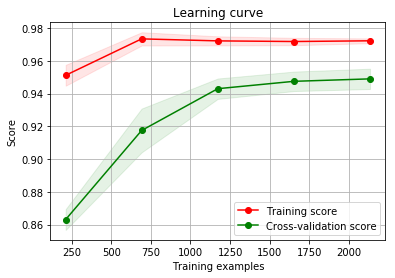

In [86]:
model = RandomForestClassifier(**best_params)
g = plot_learning_curve(model, "Learning curve", X_train, y_train, cv=5)

In [87]:
model.fit(X_train, y_train)

prediction = model.predict(X_test)
print(confusion_df(y_test, prediction))

         Predicted Class 0  Predicted Class 1
Class 0                564                  6
Class 1                 25                 72


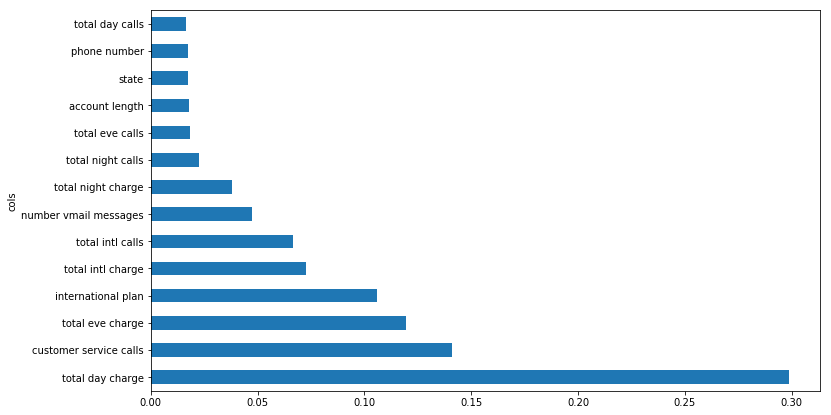

In [89]:
plot_fi(rf_feat_importance(model, X_keep));

In [91]:
rf_feat_importance(model, X_keep)

,cols,imp
0,total day charge,0.298549
1,customer service calls,0.141112
3,total eve charge,0.119492
2,international plan,0.105879
5,total intl charge,0.072847
4,total intl calls,0.066744
6,number vmail messages,0.047505
7,total night charge,0.037803
9,total night calls,0.022500
11,total eve calls,0.018379
